In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts

from collections import namedtuple

In [3]:
# Testing 4 grid struct with namedtuple

Cell = namedtuple("Cell", "elevation water_level")

In [8]:
cell = Cell(100, [0.2])

In [12]:
cell.water_level[0] = 1


cell

Cell(elevation=100, water_level=[1])

In [64]:
# Stochastic CA
N = 10

layers = 5
grid = np.zeros((N,N,layers))

for i in range(N):
    for j in range(N):
        # Use small scale as tally is easier for testing
        grid[i,j,0] -= sts.norm.pdf(i, loc = N/2, scale = N/2) + \
                    sts.norm.pdf(j, loc = N/2, scale = N/2) + 50




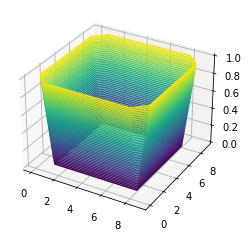

In [84]:
def view_layer(grid, layer):
    plt.imshow(grid[:,:,layer])

def show_3d_layer(grid, layer):
    fig = plt.figure()

    ax = fig.add_subplot(1,1,1, projection = '3d')
    ax.contour3D(range(N), range(N), grid[:,:,layer], 50)

show_3d_layer(grid, 1)


In [91]:

def init_water(grid, fill = 1):
    # fill (m) water in cell perimenter
    water_layer = grid[...,1]

    water_layer[0,:], water_layer[-1,:] = fill, fill
    water_layer[:,0], water_layer[:, -1] = fill, fill
    return grid

def init_flood(grid):
    flood_layer  = ...
    # calc Flood flag over grid

    return grid


NW, N, NE, W, E, SW, S, SE = [2**p for p in range(0,8)]
def init_directions(grid):
    pass






2

In [146]:
import scipy.ndimage as ndimage

moore_kernel = np.ones((3,3))
moore_kernel[1,1] = 0

directions = {k:v for k,v in zip(range(0,8), [2**p for p in range(0,8)] )}

def find_direction(x):
    # Reject is extends beyond border
    # idx is direction
    idx = x.argmin()
    
    return directions[idx]
    

rets = ndimage.generic_filter(
    grid[...,0],
    find_direction,
    footprint = moore_kernel,  
    mode = 'constant',
    cval = np.nan)

In [148]:
rets[5,5]

2.0

In [113]:
def compute_flow(x):
    # Reject is extends beyond border
    if not np.isnan(x).any():
        pass

    return 0
    

False

pre-processing input data; 

height of water column vs DEM height>
direction vs slope?
"detects water" 

for iter in iterations:
    for i in N:
        for j in N:

            cell = grid[i,j]

            is cell[water] > 0:
                if water in cell.neighborhood:
                    check direction
                        if direction towards cell 
                            if cell is activated:
                                water_spread = calc_water_spread()
                                temp_water[i,j] = sw
                            if water in cell:
                                if cell with water == activated:
                                    water_drain = calc_water_drain()
                                    temp_drain[i,j] = water_drain

    water_grid += water_spread - water_drain
    temp_drain = np.zeros((N,N))


4 grids
    1. water level
        **height of water column (float m)** in cell
            init: >0 if water else 0
    
    2. flooded cell grid
        FLOODED? **bool** flag on flooding conditions
            if flooded, can transfer water to neighboring cells
            flooding conditions:

    3. **direction** grid
        each cell [1,255]
            
        ![](./media/directions.jpg)
        preffered cell direction of water flow is one of 6 vals,
                NW, N, NE, W, E, SW, S, SE = 1,2,4,8,16,32,64,128
                *or everything lower?*
            determined by considering **height** in 8 neighbors
                lowest height = direction
                    for ex N = -10, [...EWS] = 0, N is preffered
                    N = 2 (while E = 4, W = 8 etc)
                if >1 cell have the same lowest height, 
                    use sum of directions
                    therefore, each cell [1,255] (255 if every cell has same elevation)
                
    4. slope grid
        generated from DEM, calculates **slope across neighborhood** for each cell

        tg(slope) = root(change_x^2 + change_y^2)
            df/dx = (h1,3 + h2,3 + h3,3 - h1,1 - h2,1 - h3,1) / 6
            df/dy = (h3,1 + h3,2 + h3,3 - h1,1 - h1,2 - h1,3) / 6
            h is contents of DEM in each cell (height)
                result: value of slope in degrees


Roving window upate:
    cell by cell
    cell_copy = cell.copy()
    if flooded (grid[1]) 
        check water direction (grid[2])
        check flooded cell if neighbor can deposit
        water_to_transfer = use slope grid  & flooded grid
        cell_copy = water_totransfer
    else water in cell:
        water_to_transfer = as above
        neighbors = water_to_transfer


*v* = cu_root(**depth**^2)*root(**s**)/**n**
depth = heigh of liquid column
s = slope of terrain
n = Manning roughness coefficient
    accounts for effect of **bed roughness on the flow field**.


T = width/v
width = cell width
*v* = velcocity from prev

Flooded if
    T > t (iteration time t, say, 1s)

Volume entering the cell,
    W = depth*width*v*t
    W is volume of water
    t is iteration, as before

f : velocity of inflitration (Green-and-Ampt equation)

f = K_s * (1 + (H_f * M_d) / F)
K_s : hydraulic conductivity
H_f : suction lift
M_d : soil moisture deficit
F   : total depth of infiltration

Boundary conditions
    **Absorbing** : water leaving an edge is removed from the system. 


DEM = Digital elevation model or DMT (Digital Model of Terrain)
    used to init model and params:
        grid init:
            1500m * 1500m 
            resolution 10m
            DEM for each thing, with raster 10m
                raster = resolution
                each cell = elevation info
        param init:
            Land Cover
                surface roughness, inflitration ~> rate of spread
                    rep: separate layers, or constant Manning coefficient for whole sim
                        0.011 for rocky (fast flow), 0.2 for vegetation (slow flow)           
    
(N,N,k)
    k = (elevation, roughness, infiltration)
        Named Tuple


application of transition rules; 
    on 4 grids

post-processing and generation of output layers


Optimization
source cell
    ?
1. mask for higher elevation stuff
    only check lower level stuff (flagged as OFF)
2. Watershed optimization


In [ ]:
# Erosion

# Make simplifying assumptions

# Short time scale

# Volume in terms of flow ~ erosion

3x3 convolution matrix

How does water circulate the system? 
    Runoff
    Hydrologic Production

This does not consider rainfall. How should it be added? 